# Sentiment Analysis Amazon Reviews - Classificazione a 3 Classi

Questo notebook implementa un sistema di sentiment analysis per recensioni Amazon utilizzando una classificazione a 3 classi (negativo, neutro, positivo).

## Setup Iniziale: Import delle Librerie e Preparazione dei Dati


### Import delle librerie 

In [3]:
# Import librerie base per data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import per text processing e NLP
import re
from collections import Counter
from wordcloud import WordCloud

# Import per machine learning
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Import per deep learning e transformers
import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments,
    EarlyStoppingCallback, set_seed, pipeline
)
from datasets import Dataset, DatasetDict
import evaluate

# Import per sentiment analysis tradizionale
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Import per gestione file e path
import os
import time
import random
from pathlib import Path
from tqdm import tqdm

# Import per API esterne (Gemini)
import google.generativeai as genai
import getpass

### Caricamento Dataset

In [4]:
splits = {'train': 'amazon_reviews_multi_train.csv', 'validation': 'amazon_reviews_multi_valid.csv', 'test': 'amazon_reviews_multi_test.csv'}
train = pd.read_csv("hf://datasets/micguida1/amazon_reviews_multi/" + splits["train"])
validation = pd.read_csv("hf://datasets/micguida1/amazon_reviews_multi/" + splits["validation"])
test = pd.read_csv("hf://datasets/micguida1/amazon_reviews_multi/" + splits["test"])

### Filtraggio dei dati per lingua inglese

In [5]:
#Seleziono solo le recensioni in inglese
train_en = train[train.language == "en"]
valid_en = validation[validation.language == "en"]
test_en = test[test.language == "en"]

## Exploratory Data Analysis (EDA)

### Distribuzione delle classi nei dataset

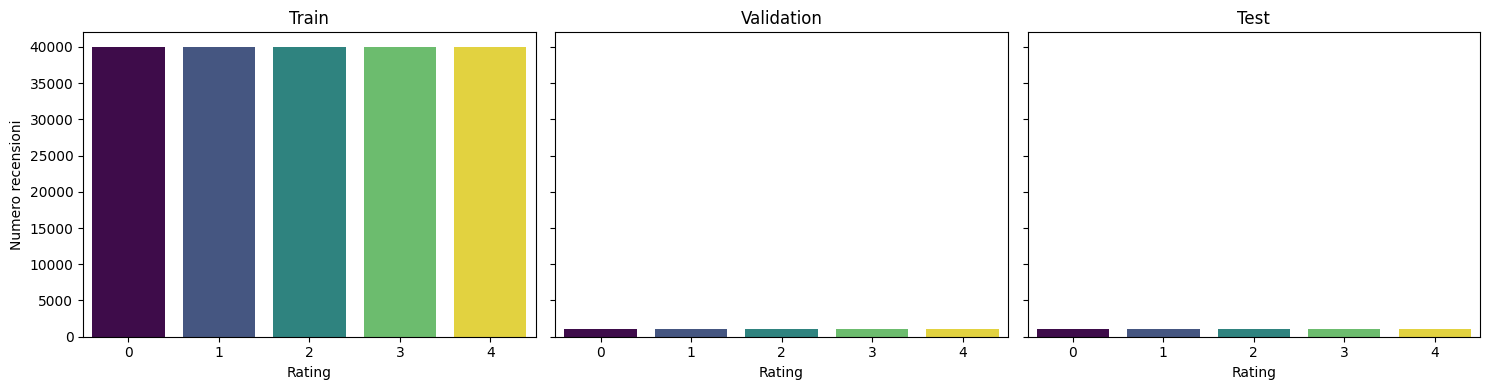

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)

sns.countplot(data=train_en, x="label", hue="label", palette="viridis", legend=False, ax=axes[0])
axes[0].set_title("Train")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Numero recensioni")

sns.countplot(data=valid_en, x="label", hue="label", palette="viridis", legend=False, ax=axes[1])
axes[1].set_title("Validation")
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("")

sns.countplot(data=test_en, x="label", hue="label", palette="viridis", legend=False, ax=axes[2])
axes[2].set_title("Test")
axes[2].set_xlabel("Rating")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

I 3 grafici mostrano la **distribuzione dei rating** (da 0 a 4) nei 3 split del dataset: **trainining, validation e test**.
Nel training set, la distribuzione è uniforme: ogni classe di rating ha lo stesso numero di esempi. Questo implica che il modello NON sarà spinto a favorire una classe rispetto alle altre.
Gli altri 2 split hanno una dimensione ridotta, ma mantengono la stessa proporzione bilanciate. Anche nella valutazione NON ci saranno bias legati a classi sbilanciate. Risulta particolarmente cruciale nel task di sentiment analysis, in quanto le metriche riflettono realmente la capacità del modello di distinguere le diverse polarità.

### Istogrammi per la visualizzazione della distribuzione delle lunghezze delle recensioni

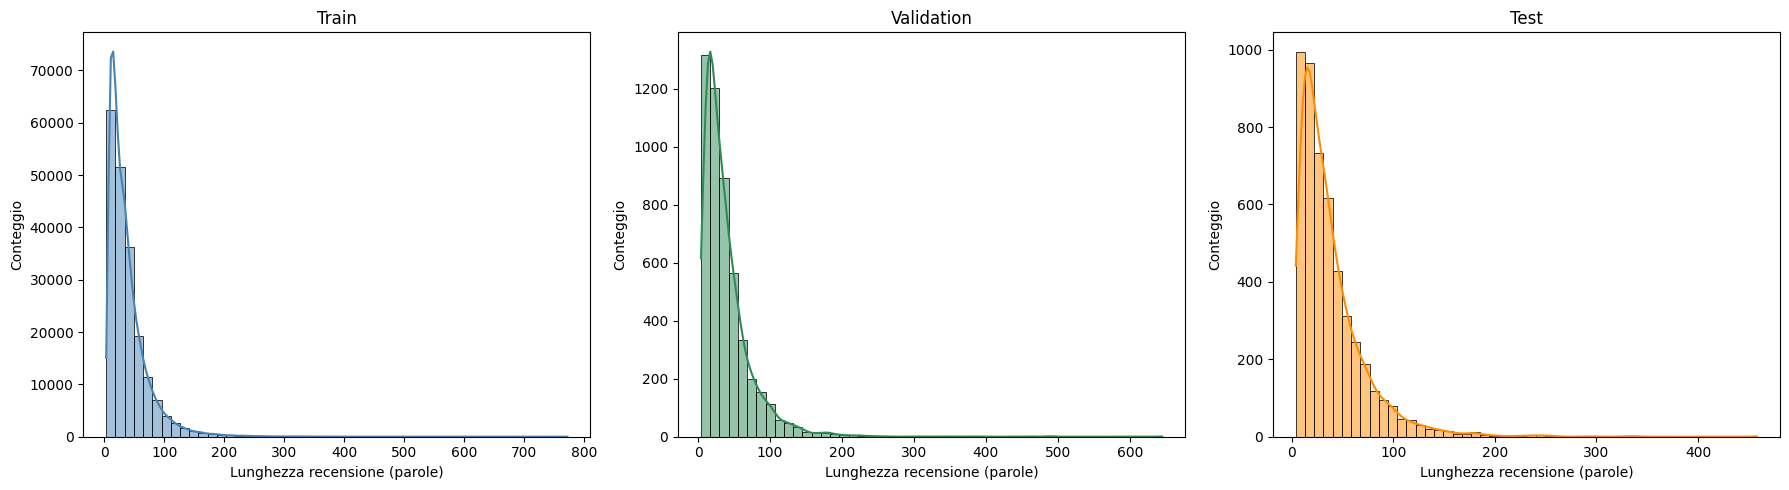

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crea/aggiorna la colonna text_len senza SettingWithCopyWarning
train_en = train_en.assign(text_len=train_en["text"].str.split().str.len())
valid_en = valid_en.assign(text_len=valid_en["text"].str.split().str.len())
test_en  = test_en.assign(text_len=test_en["text"].str.split().str.len())

# Tre istogrammi affiancati, scale indipendenti
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=False)

sns.histplot(train_en["text_len"], bins=50, kde=True, color="steelblue", ax=axes[0])
axes[0].set_title("Train")
axes[0].set_xlabel("Lunghezza recensione (parole)")
axes[0].set_ylabel("Conteggio")

sns.histplot(valid_en["text_len"], bins=50, kde=True, color="seagreen", ax=axes[1])
axes[1].set_title("Validation")
axes[1].set_xlabel("Lunghezza recensione (parole)")
axes[1].set_ylabel("Conteggio")

sns.histplot(test_en["text_len"], bins=50, kde=True, color="darkorange", ax=axes[2])
axes[2].set_title("Test")
axes[2].set_xlabel("Lunghezza recensione (parole)")
axes[2].set_ylabel("Conteggio")

plt.tight_layout()
plt.show()


I 3 istrogrammi mostrano la distribuzione della lunghezza delle recensioni nei tre split: training, validation e test.
Si può notare che la maggior parte delle recensioni è piuttosto breve, la distribuzione è fortemente skewed a dx. Lo stesso vale per Validation e Test set. Confermando cosi che gli split sono coerenti tra loro.

### Boxplot per la visualizzazione della distribuzione delle lunghezze delle recensioni per rating nel training set

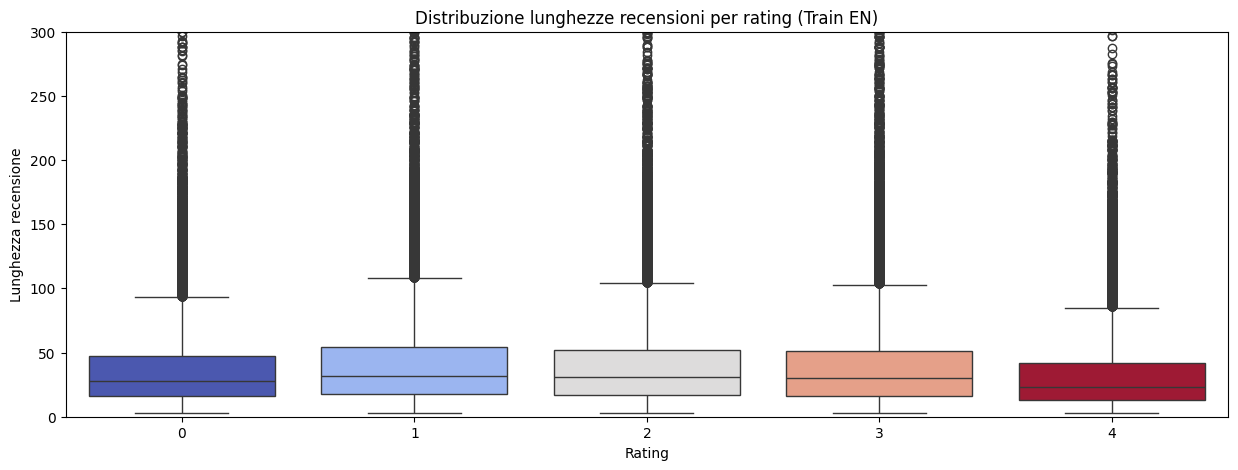

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
sns.boxplot(
    data=train_en,
    x="label",
    y="text_len",
    hue="label",       # serve per usare la palette
    palette="coolwarm",
    legend=False       # evita di mostrare la legenda duplicata
)
plt.title("Distribuzione lunghezze recensioni per rating (Train EN)")
plt.xlabel("Rating")
plt.ylabel("Lunghezza recensione")
plt.ylim(0, 300)  # taglio outlier per renderlo più leggibile
plt.show()


I boxplot mostrano la distribuzione della lunghezza delle recensioni all'interno del training set, per ciascun rating.
Per tutte le classi l'IQR rimane abbastanza simile, per cui la maggior parte delle recensioni ha una lunghezza paragonabile indipendentemente dal rating.
I punti fuori dai whiskers confermano la presenza di outliers già osservata negli istogrammi.
Pertanto la lunghezza del testo risulta una caratteristica poco discriminante tra le diverse classi di rating per predire il sentiment.

## Mappatura delle Classi



### Mappatura dei Rating in Sentiment (3 classi)

Trasformiamo i rating numerici (0-4) in categorie di sentiment più intuitive:
- **neg** (negativo): rating 0-1 stelle 
- **neu** (neutro): rating 2 stelle (3 stelle)
- **pos** (positivo): rating 3-4 stelle (4-5 stelle)

Questa mappatura ci permette di lavorare con 3 classi per l'analisi del sentiment.

In [9]:
def map_sentiment(label):
    if label in [0, 1]:  # 1–2 stars
        return "neg"
    elif label == 2:     # 3 stars
        return "neu"
    else:                # 4–5 stars
        return "pos"

train_en["sentiment"] = train_en["label"].apply(map_sentiment)
valid_en["sentiment"] = valid_en["label"].apply(map_sentiment)
test_en["sentiment"]  = test_en["label"].apply(map_sentiment)

### Word Cloud per le tre classi di sentiment

Visualizziamo le parole più frequenti per ogni classe di sentiment utilizzando delle word cloud colorate:
- **Negativo** (rosso): rating 0-1 stelle
- **Neutro** (nero): rating 2 stelle  
- **Positivo** (verde): rating 3-4 stelle

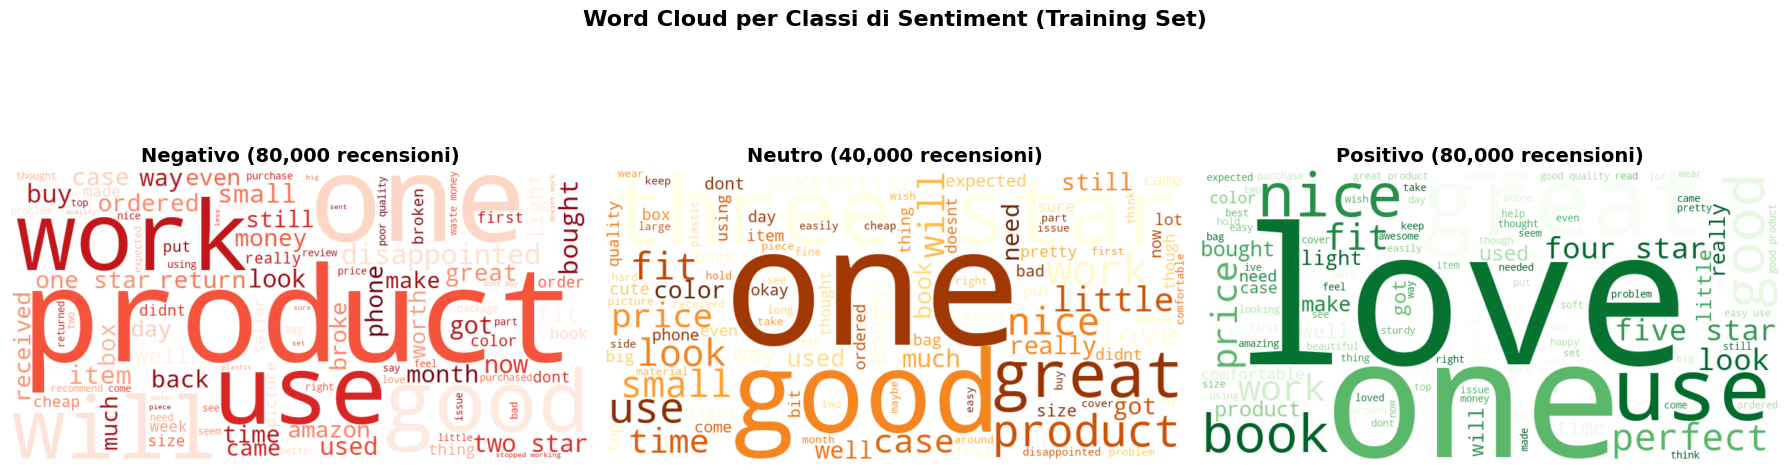

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import re

# Preprocessing del testo per le word cloud
def preprocess_text(text):
    # Converti in minuscolo e rimuovi caratteri speciali
    text = str(text).lower()
    # Rimuovi punteggiatura e numeri, mantieni solo lettere e spazi
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Rimuovi parole molto corte (meno di 3 caratteri)
    words = [word for word in text.split() if len(word) >= 3]
    return ' '.join(words)

# Prepara i testi per ogni classe di sentiment
texts_by_sentiment = {
    'neg': train_en[train_en['sentiment'] == 'neg']['text'].apply(preprocess_text).str.cat(sep=' '),
    'neu': train_en[train_en['sentiment'] == 'neu']['text'].apply(preprocess_text).str.cat(sep=' '),
    'pos': train_en[train_en['sentiment'] == 'pos']['text'].apply(preprocess_text).str.cat(sep=' ')
}

# Definisci i colori per ogni sentiment
colors = {
    'neg': 'Reds',      # Rosso per negativo
    'neu': 'YlOrBr',    # Giallo per neutro  
    'pos': 'Greens'     # Verde per positivo
}

# Crea le word cloud
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (sentiment, text) in enumerate(texts_by_sentiment.items()):
    # Crea la word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap=colors[sentiment],
        max_words=100,
        relative_scaling=0.5,
        random_state=123
    ).generate(text)
    
    # Plot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    
    # Titolo con conteggio recensioni
    count = len(train_en[train_en['sentiment'] == sentiment])
    sentiment_names = {'neg': 'Negativo', 'neu': 'Neutro', 'pos': 'Positivo'}
    axes[i].set_title(f'{sentiment_names[sentiment]} ({count:,} recensioni)', 
                     fontsize=14, fontweight='bold')

plt.suptitle('Word Cloud per Classi di Sentiment (Training Set)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
# Analisi delle parole più frequenti per ogni sentiment
print("=== ANALISI PAROLE PIÙ FREQUENTI PER SENTIMENT ===\n")

for sentiment in ['neg', 'neu', 'pos']:
    text = texts_by_sentiment[sentiment]
    words = text.split()
    word_freq = Counter(words)
    
    sentiment_names = {'neg': 'NEGATIVO', 'neu': 'NEUTRO', 'pos': 'POSITIVO'}
    print(f"{sentiment_names[sentiment]} - Top 15 parole:")
    
    for word, freq in word_freq.most_common(15):
        print(f"   {word}: {freq:,}")
    print()

=== ANALISI PAROLE PIÙ FREQUENTI PER SENTIMENT ===

NEGATIVO - Top 15 parole:
   the: 155,230
   and: 78,197
   not: 59,850
   this: 43,262
   for: 37,020
   was: 35,496
   but: 31,208
   that: 21,592
   with: 20,447
   have: 19,525
   one: 19,188
   they: 18,684
   very: 17,799
   you: 16,066
   product: 15,026

NEUTRO - Top 15 parole:
   the: 85,869
   and: 37,475
   but: 27,307
   not: 24,705
   for: 23,081
   was: 16,273
   this: 16,254
   that: 13,071
   have: 10,900
   with: 10,818
   they: 10,167
   its: 9,488
   are: 9,474
   good: 9,254
   you: 9,240

POSITIVO - Top 15 parole:
   the: 126,476
   and: 85,573
   for: 48,055
   this: 39,712
   great: 32,410
   but: 29,867
   good: 24,016
   with: 23,428
   was: 21,849
   that: 21,669
   very: 21,562
   have: 18,850
   not: 18,497
   are: 16,977
   they: 16,494




=== VADER — TEST SET ===
Accuracy: 0.5892
F1-macro: 0.48224089791094293
              precision    recall  f1-score   support

         neg      0.729     0.530     0.614      2000
         neu      0.199     0.093     0.127      1000
         pos      0.582     0.896     0.706      2000

    accuracy                          0.589      5000
   macro avg      0.503     0.506     0.482      5000
weighted avg      0.564     0.589     0.553      5000



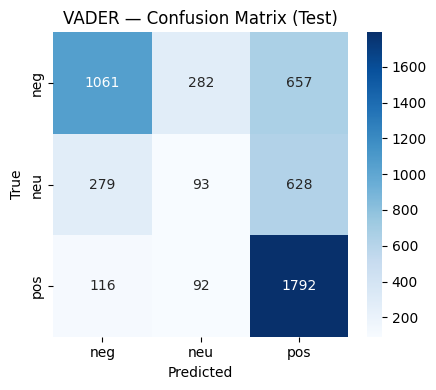

In [12]:
# --- Import ---
import nltk
nltk.download("vader_lexicon", quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Inizializza VADER ---
sia = SentimentIntensityAnalyzer()

# --- Funzione: compound -> neg/neu/pos ---
def vader_sentiment(text, pos_thresh=0.05, neg_thresh=-0.05):
    score = sia.polarity_scores(text)["compound"]
    if score >= pos_thresh:
        return "pos"
    elif score <= neg_thresh:
        return "neg"
    else:
        return "neu"

# --- Prediction su test ---
test_preds_vader = test_en["text"].apply(vader_sentiment)

print("\n=== VADER — TEST SET ===")
print("Accuracy:", accuracy_score(test_en["sentiment"], test_preds_vader))
print("F1-macro:", f1_score(test_en["sentiment"], test_preds_vader, average="macro"))
print(classification_report(test_en["sentiment"], test_preds_vader, digits=3))

# --- Confusion Matrix ---
CLASSES = ["neg","neu","pos"]
cm = confusion_matrix(test_en["sentiment"], test_preds_vader, labels=CLASSES)
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("VADER — Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# Modelli di Sentiment Analysis

## Baseline: VADER Sentiment Analyzer

VADER (Valence Aware Dictionary and sEntiment Reasoner) è un modello basato su regole e dizionario per l'analisi del sentiment.

In [ ]:
# === Gemini evaluation: polarity neg/neu/pos (batch, seed param) ==================
import os, time, re, random
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import display

# --------------------------------------------------------------------------
# 0) Segreti Colab / Config Gemini
# --------------------------------------------------------------------------
try:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
except Exception:
    GEMINI_API_KEY = None
if not GEMINI_API_KEY:
    import getpass
    GEMINI_API_KEY = getpass.getpass("Inserisci GEMINI_API_KEY: ")

import google.generativeai as genai
genai.configure(api_key=GEMINI_API_KEY)

MODEL_NAME = "gemini-2.0-flash-lite"  # oppure "gemini-2.5-flash" per più velocità/costi

# --------------------------------------------------------------------------
# 1) Prompt: risposta SOLO in {neg, neu, pos}
# --------------------------------------------------------------------------
INSTRUCTIONS = """Sei un classificatore di sentiment.
Per OGNI recensione, rispondi ESATTAMENTE con UNA sola parola tra:
neg, neu, pos

Regole:
- Niente spiegazioni, niente punteggiatura, niente virgolette.
- Se incerto, rispondi "neu".
- Output: una label per riga, nello stesso ordine delle recensioni.
"""

def build_header() -> str:
    return INSTRUCTIONS

# --------------------------------------------------------------------------
# 2) Chiamata a Gemini in batch (ritorna ['neg'|'neu'|'pos', ...])
# --------------------------------------------------------------------------
LABEL_RE = re.compile(r"\b(neg|neu|pos)\b", re.IGNORECASE)

def _coerce_label(s: str) -> str:
    s = (s or "").strip().lower()
    # pulizia minimale
    s = re.sub(r"[^a-z]", "", s)
    if s in ("neg", "neu", "pos"): return s
    # sinonimi accidentali
    if s.startswith("neg"): return "neg"
    if s.startswith("neu"): return "neu"
    if s.startswith("pos"): return "pos"
    if "negative" in s: return "neg"
    if "neutral"  in s: return "neu"
    if "positive" in s: return "pos"
    return "neu"

def gemini_batch_polarity(reviews: list[str], max_retries=4, sleep_base=0.6) -> list[str]:
    """
    Classifica più recensioni in un'unica chiamata (neg/neu/pos).
    Ritorna una lista di stringhe in {'neg','neu','pos'} nello stesso ordine di input.
    """
    header = build_header()
    lines = [header, "Ora classifica queste recensioni (una label per riga nello stesso ordine):"]
    for i, rev in enumerate(reviews, 1):
        rev_oneline = " ".join(str(rev).split())
        # Format comodo da parsare: riga con indice + testo, poi "Label:"
        lines.append(f"{i}) Review: \"{rev_oneline}\"\nLabel:")

    prompt = "\n".join(lines)

    gen_cfg = genai.GenerationConfig(
        temperature=0,
        max_output_tokens=max(64, 3 * len(reviews) + 16),  # ~3 token/riga + margine
    )
    model = genai.GenerativeModel(MODEL_NAME, generation_config=gen_cfg)

    for attempt in range(max_retries):
        try:
            resp = model.generate_content(prompt)
            raw = (getattr(resp, "text", "") or "").strip()
            # split riga per riga, prendendo la prima occorrenza valida
            out_lines = [l.strip() for l in raw.splitlines() if l.strip()]
            preds = []
            for l in out_lines:
                m = LABEL_RE.search(l)
                if m:
                    preds.append(_coerce_label(m.group(1)))
            if len(preds) < len(reviews):
                preds += ["neu"] * (len(reviews) - len(preds))  # fallback neutro
            return preds[:len(reviews)]
        except Exception:
            # backoff esponenziale + jitter
            time.sleep(sleep_base * (2 ** attempt) + random.random() * 0.1)

    return ["neu"] * len(reviews)  # fallback finale

def gemini_label_polarity(review: str) -> str:
    return gemini_batch_polarity([review])[0]

# --------------------------------------------------------------------------
# 3) Valutazione su TUTTO il test set (robusta, con checkpoint)
# --------------------------------------------------------------------------
from pathlib import Path

CHECKPOINT_PATH = Path("/content/gemini_preds_checkpoint.parquet")  # cambia se vuoi
RESULTS_PATH    = Path("/content/gemini_results.parquet")

# Usa l'intero dataset
texts_all = test_en["text"].astype(str).tolist()
y_true_0_4_all = test_en["label"].astype(int).tolist()

def gold_to_polarity(x: int) -> str:
    if x in (0, 1): return "neg"
    if x == 2:      return "neu"
    return "pos"

y_true_all = [gold_to_polarity(x) for x in y_true_0_4_all]

# Parametri
BATCH_SIZE = 8          # 5–10 è stabile; se vedi rate limit, abbassa
SAVE_EVERY = 200        # salva ogni N batch
SEED = 123

# Riprendi da checkpoint se esiste
start_idx = 0
preds_all = [None] * len(texts_all)
if CHECKPOINT_PATH.exists():
    try:
        ck = pd.read_parquet(CHECKPOINT_PATH)
        # il checkpoint contiene colonne: idx, pred
        for _, row in ck.iterrows():
            preds_all[int(row["idx"])] = row["pred"]
        start_idx = int(ck["idx"].max()) + 1
        print(f"[CKPT] Riprendo da indice {start_idx} (trovate {ck.shape[0]} predizioni).")
    except Exception as e:
        print(f"[CKPT] Errore nel leggere il checkpoint, riparto da zero. Dettagli: {e}")

# Funzione per salvare checkpoint incrementale
def save_ckpt(preds_list, upto_idx):
    rows = [{"idx": i, "pred": p} for i, p in enumerate(preds_list[:upto_idx]) if p is not None]
    if rows:
        pd.DataFrame(rows).to_parquet(CHECKPOINT_PATH, index=False)

# Loop su TUTTE le recensioni
num_batches = (len(texts_all) - start_idx + BATCH_SIZE - 1) // BATCH_SIZE
pbar = tqdm(range(start_idx, len(texts_all), BATCH_SIZE), total=num_batches,
            desc=f"Gemini batch full (batch={BATCH_SIZE})")

bcount = 0
for i in pbar:
    batch = texts_all[i:i+BATCH_SIZE]
    try:
        out = gemini_batch_polarity(batch)
    except Exception as e:
        # retry semplice in caso di errori transienti
        time.sleep(1.0)
        try:
            out = gemini_batch_polarity(batch)
        except Exception as e2:
            print(f"[WARN] Batch {i}-{i+len(batch)} fallito due volte: {e2}. Filler 'neu'.")
            out = ["neu"] * len(batch)

    preds_all[i:i+len(batch)] = out
    bcount += 1

    # salva ogni SAVE_EVERY batch
    if bcount % SAVE_EVERY == 0:
        save_ckpt(preds_all, i + len(batch))

# Salvataggio finale
save_ckpt(preds_all, len(texts_all))

# Verifica che non ci siano buchi; riempi eventuali None con 'neu'
num_none = sum(p is None for p in preds_all)
if num_none:
    print(f"[WARN] {num_none} predizioni mancanti. Riempi con 'neu'.")
    preds_all = [p if p is not None else "neu" for p in preds_all]

# --------------------------------------------------------------------------
# 4) Metriche + salvataggi risultati
# --------------------------------------------------------------------------
CLASSES_3 = ["neg", "neu", "pos"]

print(f"\n=== GEMINI — polarity (full test), size={len(texts_all)}, batch={BATCH_SIZE} ===")
print("Accuracy:", accuracy_score(y_true_all, preds_all))
print("F1-macro:", f1_score(y_true_all, preds_all, average="macro"))
print(classification_report(y_true_all, preds_all, labels=CLASSES_3, digits=3))

# salva risultati completi (utile per analisi errori)
df_out = pd.DataFrame({
    "gold_polarity": y_true_all,
    "pred_polarity": preds_all,
    "text": texts_all
})
df_out.to_parquet(RESULTS_PATH, index=False)
print(f"\n[OK] Salvati i risultati completi in: {RESULTS_PATH}")
print(f"[OK] Checkpoint in: {CHECKPOINT_PATH}")

# Confusion Matrix
cm = confusion_matrix(y_true_all, preds_all, labels=CLASSES_3)
plt.figure(figsize=(5.2,4.6))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Gemini — Confusion Matrix 3-class (full test)")
plt.xticks(range(len(CLASSES_3)), CLASSES_3)
plt.yticks(range(len(CLASSES_3)), CLASSES_3)
for (r, c), v in np.ndenumerate(cm):
    plt.text(c, r, str(v), ha='center', va='center')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


Gemini batch full (batch=8):   2%|▏         | 12/625 [16:34<31:22:42, 184.28s/it]

## Gemini API: Large Language Model

Utilizziamo Google Gemini per il sentiment analysis tramite prompting diretto.

In [ ]:
# ======================= Install =======================
!pip -q install -U transformers datasets evaluate accelerate scikit-learn

# ======================= Imports & Seed =======================
import os, numpy as np, pandas as pd, torch, random
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from datasets import Dataset, DatasetDict
import evaluate
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments,
    EarlyStoppingCallback, set_seed
)
set_seed(123)

# ======================= Data prep (0-4 -> 3 classi) =======================
assert 'train_en' in globals() and 'test_en' in globals(), "Serve train_en/test_en con colonne: text,label."

def map_0_4_to_3(x:int)->int:
    # 0-1 -> 0(neg), 2 -> 1(neu), 3-4 -> 2(pos)
    return 0 if x in (0,1) else (1 if x==2 else 2)

train_df = train_en[['text','label']].dropna().copy()
test_df  = test_en[['text','label']].dropna().copy()
train_df['label3'] = train_df['label'].astype(int).apply(map_0_4_to_3)
test_df['label3']  = test_df['label'].astype(int).apply(map_0_4_to_3)

# split stratificato 90/10 per validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=123)
tr_idx, va_idx = next(sss.split(train_df, train_df['label3']))
train_split = train_df.iloc[tr_idx].reset_index(drop=True)
val_split   = train_df.iloc[va_idx].reset_index(drop=True)

# HF datasets (evitiamo colonne spurie)
def to_hfds(df):
    return Dataset.from_dict({'text': df['text'].astype(str).tolist(),
                              'labels': df['label3'].astype(int).tolist()})
ds = DatasetDict(
    train=to_hfds(train_split),
    validation=to_hfds(val_split),
    test=to_hfds(test_df)
)

# ======================= Model & Tokenizer =======================
MODEL_NAME = "microsoft/deberta-v3-base"
id2label = {0:"neg", 1:"neu", 2:"pos"}
label2id = {v:k for k,v in id2label.items()}

tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def preprocess(batch):
    return tok(batch['text'], truncation=True, max_length=256)
ds_tok = ds.map(preprocess, batched=True, remove_columns=['text'])
collator = DataCollatorWithPadding(tokenizer=tok, pad_to_multiple_of=8)

dtype_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
    torch_dtype=torch.bfloat16 if dtype_bf16 else None
)
# Memory/VRAM tricks
model.gradient_checkpointing_enable()
torch.backends.cuda.matmul.allow_tf32 = True

# ======================= Class Weights (sbilanciamento) =======================
cls_counts = train_split['label3'].value_counts().sort_index().to_numpy()  # [neg, neu, pos]
freq = cls_counts / cls_counts.sum()
weights = (1.0 / (freq + 1e-9))
weights = weights / weights.mean()
class_weights = torch.tensor(weights, dtype=torch.float)
print("Class weights (neg, neu, pos):", class_weights.tolist())

# ======================= Trainer con loss pesata =======================
from torch.nn import CrossEntropyLoss
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        cw = self.class_weights.to(logits.device) if self.class_weights is not None else None
        loss_fct = CrossEntropyLoss(weight=cw)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# ======================= Metrics =======================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

# ======================= Training args (Colab-safe) =======================
per_dev_bs = 8
grad_accum = 4  # eff. batch 32
args = TrainingArguments(
    output_dir="deberta_v3_base_sa",
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=per_dev_bs,
    per_device_eval_batch_size=max(16, per_dev_bs),
    gradient_accumulation_steps=grad_accum,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=(not dtype_bf16) and torch.cuda.is_available(),
    bf16=dtype_bf16,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ======================= Train =======================
train_result = trainer.train()
print("Best checkpoint:", trainer.state.best_model_checkpoint)

# ======================= Val/Test Eval =======================
print("\nValidation metrics:", trainer.evaluate(ds_tok["validation"]))

test_preds = trainer.predict(ds_tok["test"])
test_y = test_preds.label_ids
test_hat = np.argmax(test_preds.predictions, axis=-1)
print("\n=== TEST ===")
print("Accuracy:", accuracy_score(test_y, test_hat))
print("F1-macro:", f1_score(test_y, test_hat, average="macro"))
print(classification_report(test_y, test_hat, target_names=[id2label[i] for i in range(3)], digits=3))

# Confusion Matrix
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(test_y, test_hat, labels=[0,1,2])
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm, interpolation='nearest')
plt.title("DeBERTa-v3-base — Confusion Matrix (test)")
plt.xticks(range(3), [id2label[i] for i in range(3)])
plt.yticks(range(3), [id2label[i] for i in range(3)])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# ======================= Save & Inference =======================
save_dir = "deberta_v3_base_sa/best"
trainer.save_model(save_dir)
tok.save_pretrained(save_dir)
print(f"Modello salvato in: {save_dir}")

# Esempio inference
from transformers import pipeline
clf = pipeline("text-classification", model=save_dir, tokenizer=sav_


## Fine-tuning: DeBERTa-v3-base

Implementiamo un modello transformer fine-tuned specificamente per il nostro dataset di sentiment analysis.

In [ ]:
!pip install wordcloud -q

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import re

# Preprocessing del testo per le word cloud
def preprocess_text(text):
    # Converti in minuscolo e rimuovi caratteri speciali
    text = str(text).lower()
    # Rimuovi punteggiatura e numeri, mantieni solo lettere e spazi
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Rimuovi parole molto corte (meno di 3 caratteri)
    words = [word for word in text.split() if len(word) >= 3]
    return ' '.join(words)

# Prepara i testi per ogni classe di sentiment
texts_by_sentiment = {
    'neg': train_en[train_en['sentiment'] == 'neg']['text'].apply(preprocess_text).str.cat(sep=' '),
    'neu': train_en[train_en['sentiment'] == 'neu']['text'].apply(preprocess_text).str.cat(sep=' '),
    'pos': train_en[train_en['sentiment'] == 'pos']['text'].apply(preprocess_text).str.cat(sep=' ')
}

# Definisci i colori per ogni sentiment
colors = {
    'neg': 'Reds',      # Rosso per negativo
    'neu': 'YlOrBr',    # Giallo per neutro  
    'pos': 'Greens'     # Verde per positivo
}

# Crea le word cloud
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (sentiment, text) in enumerate(texts_by_sentiment.items()):
    # Crea la word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap=colors[sentiment],
        max_words=100,
        relative_scaling=0.5,
        random_state=123
    ).generate(text)
    
    # Plot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    
    # Titolo con conteggio recensioni
    count = len(train_en[train_en['sentiment'] == sentiment])
    sentiment_names = {'neg': 'Negativo', 'neu': 'Neutro', 'pos': 'Positivo'}
    axes[i].set_title(f'{sentiment_names[sentiment]} ({count:,} recensioni)', 
                     fontsize=14, fontweight='bold')

plt.suptitle('Word Cloud per Classi di Sentiment (Training Set)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()